In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
df = pd.read_csv("topassist.csv")

In [4]:
df.head()

,Season,Rank,Player,Club,Age,Position,Minutes_Played,Assists_prev_season,Goals_prev_season,Assists,...,Shots_Assisted,Set_Piece_Involvement,Club_Total_Goals,Club_League_Rank,Big6_Club_Feature,Club_Attack_Share,Club_xG,Assists_per_90,xA_per_90,Key_Passes_per_90
0,2023-24,1,Ollie Watkins,Aston Villa,28,Forward,3350,15.0,14.0,13,...,55,No,76,4,No,0.42,66.9,0.35,0.17,1.48
1,2023-24,2,Cole Palmer,Chelsea,22,Midfielder,2985,3.0,3.0,11,...,46,Yes,77,6,Yes,0.43,62.2,0.33,0.19,1.38
2,2023-24,3,Anthony Gordon,Newcastle United,23,Winger,2954,2.0,11.0,10,...,48,No,85,7,No,0.25,65.3,0.30,0.18,1.46
3,2023-24,4,Kevin De Bruyne,Manchester City,32,Midfielder,1121,16.0,7.0,10,...,38,Yes,96,1,Yes,0.27,78.5,0.80,0.47,3.05
4,2023-24,5,Pascal Groß,Brighton,33,Midfielder,3241,8.0,9.0,10,...,58,Yes,55,11,No,0.35,59.3,0.28,0.20,1.61


In [5]:
df.columns

Index(['Season', 'Rank', 'Player', 'Club', 'Age', 'Position', 'Minutes_Played',
       'Assists_prev_season', 'Goals_prev_season', 'Assists', 'Key_Passes',
       'Expected_Assists_(xA)', 'Crosses_Completed', 'Dribbles_Completed',
       'Shots_Assisted', 'Set_Piece_Involvement', 'Club_Total_Goals',
       'Club_League_Rank', 'Big6_Club_Feature', 'Club_Attack_Share', 'Club_xG',
       'Assists_per_90', 'xA_per_90', 'Key_Passes_per_90'],
      dtype='object')

In [6]:
df.isnull().sum()

Season                     0
Rank                       0
Player                     0
Club                       0
Age                        0
Position                   0
Minutes_Played             0
Assists_prev_season      108
Goals_prev_season         88
Assists                    0
Key_Passes                 0
Expected_Assists_(xA)      0
Crosses_Completed        320
Dribbles_Completed         0
Shots_Assisted             0
Set_Piece_Involvement      0
Club_Total_Goals           0
Club_League_Rank           0
Big6_Club_Feature          0
Club_Attack_Share          0
Club_xG                    0
Assists_per_90             0
xA_per_90                  0
Key_Passes_per_90          0
dtype: int64

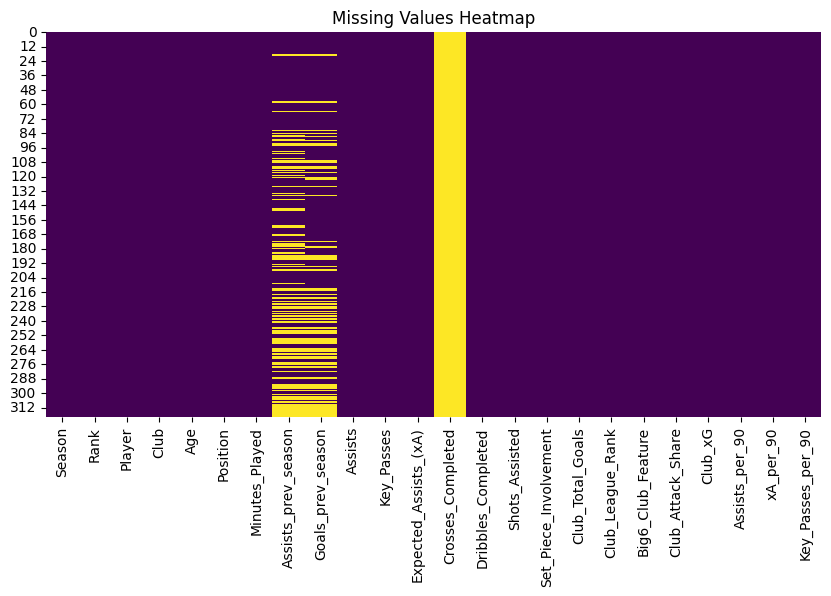

In [7]:
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

In [8]:
df = df.dropna(subset=['Assists_prev_season'])

In [9]:
df['Goals_prev_season'] = df['Goals_prev_season'].fillna(df['Goals_prev_season'].median())

In [10]:
unwanted_cols = ['Season', 'Rank', 'Player', 'Club',
    'Crosses_Completed', 'Assists_per_90',
    'xA_per_90', 'Key_Passes_per_90']
df = df.drop(columns=unwanted_cols, errors='ignore')
df.columns

Index(['Age', 'Position', 'Minutes_Played', 'Assists_prev_season',
       'Goals_prev_season', 'Assists', 'Key_Passes', 'Expected_Assists_(xA)',
       'Dribbles_Completed', 'Shots_Assisted', 'Set_Piece_Involvement',
       'Club_Total_Goals', 'Club_League_Rank', 'Big6_Club_Feature',
       'Club_Attack_Share', 'Club_xG'],
      dtype='object')

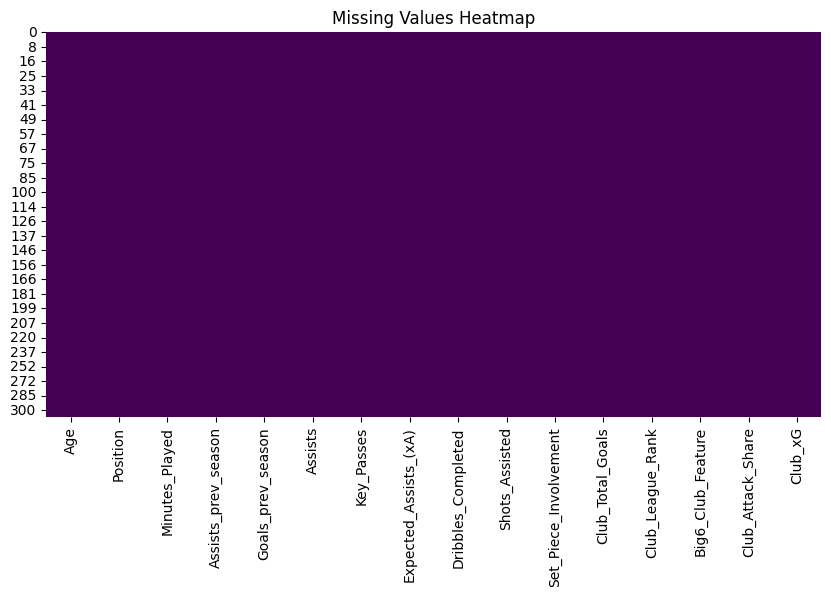

In [11]:
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

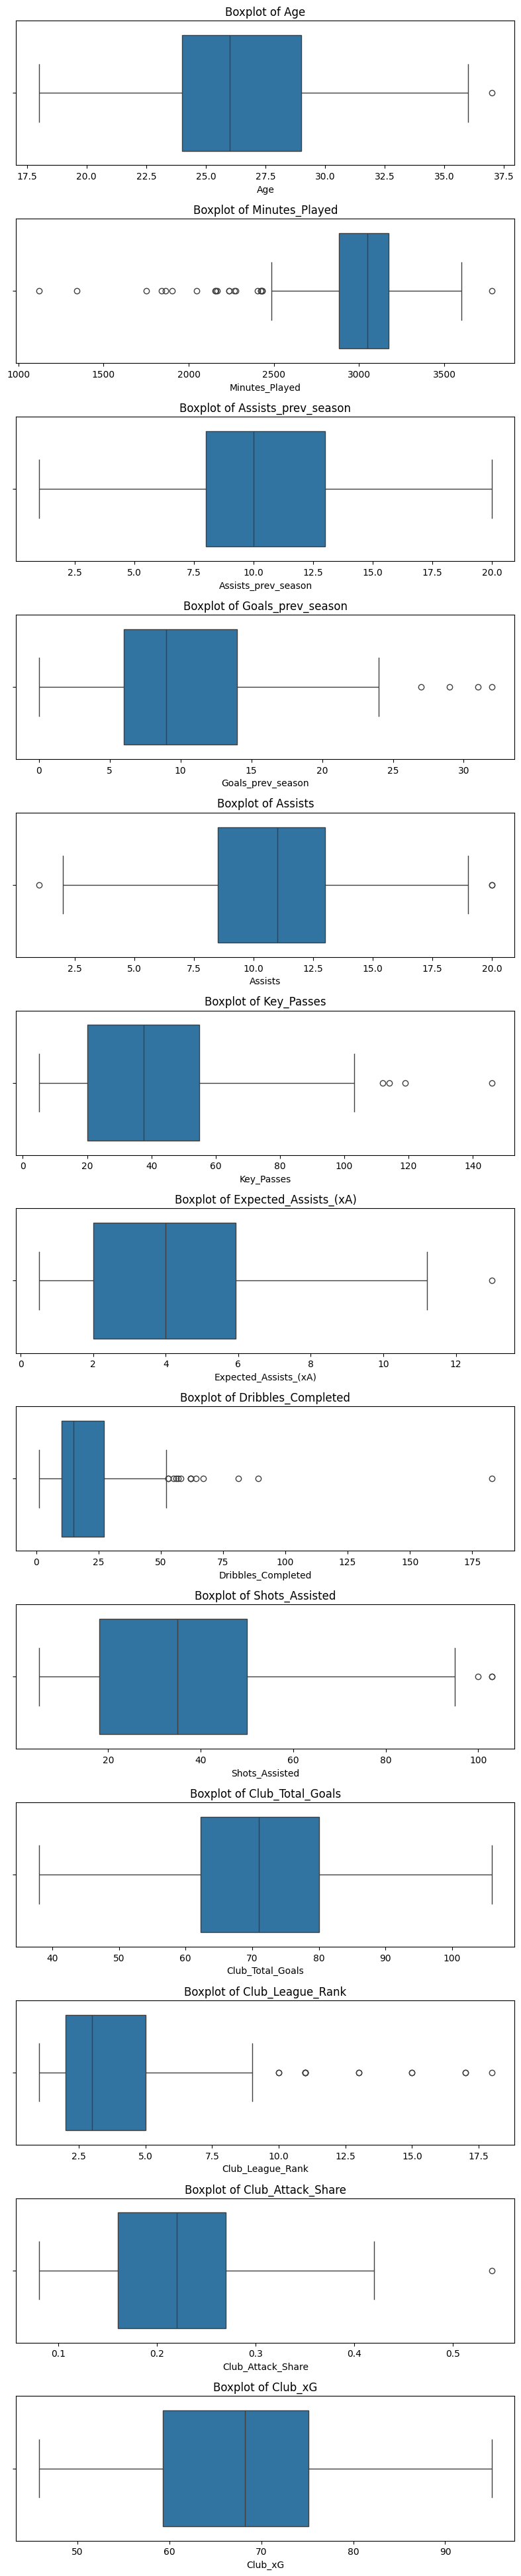

                      num_outliers  \
Age                              1   
Minutes_Played                  20   
Assists_prev_season              0   
Goals_prev_season                4   
Assists                          3   
Key_Passes                       4   
Expected_Assists_(xA)            1   
Dribbles_Completed              14   
Shots_Assisted                   3   
Club_Total_Goals                 0   
Club_League_Rank                13   
Club_Attack_Share                1   
Club_xG                          0   

                                                         sample_outliers  
Age                                                                 [37]  
Minutes_Played         [1121, 2425, 1750, 2166, 1343, 1839, 1863, 227...  
Assists_prev_season                                                   []  
Goals_prev_season                               [32.0, 27.0, 29.0, 31.0]  
Assists                                                          [20, 1]  
Key_Passes       

In [13]:
numeric_cols = [
    'Age', 'Minutes_Played', 'Assists_prev_season', 'Goals_prev_season',
    'Assists', 'Key_Passes', 'Expected_Assists_(xA)',
    'Dribbles_Completed', 'Shots_Assisted',
    'Club_Total_Goals', 'Club_League_Rank', 'Club_Attack_Share', 'Club_xG'
]

fig, axes = plt.subplots(nrows=len(numeric_cols), ncols=1, figsize=(8, 3*len(numeric_cols)))

outlier_summary = {}
df_clean = df.copy()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df_clean[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
    
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)][col]
    
    outlier_summary[col] = {
        "num_outliers": len(outliers),
        "sample_outliers": outliers.unique()[:10]  
    }
    
    # Remove outliers
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

plt.tight_layout()
plt.show()

outlier_df = pd.DataFrame(outlier_summary).T
print(outlier_df)

print("\nOriginal shape:", df.shape)
print("Cleaned shape:", df_clean.shape)


In [14]:
df = df_clean
from sklearn.preprocessing import LabelEncoder

cat_cols = df.select_dtypes(include=['object']).columns

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [15]:
df["Assists_per_90"] = df["Assists"] / (df["Minutes_Played"] / 90)
df["Goals_per_90"] = df["Goals_prev_season"] / (df["Minutes_Played"] / 90)
df["Contribution_Ratio"] = (df["Assists"] + df["Goals_prev_season"]) / df["Club_Total_Goals"]
df["Dribbles_per_90"] = df["Dribbles_Completed"] / (df["Minutes_Played"] / 90)
df["Shots_Assisted_per_90"] = df["Shots_Assisted"] / (df["Minutes_Played"] / 90)

In [16]:
X = df.drop(columns=["Assists"])
y = df["Assists"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = LinearRegression()
# model.fit(X_train, y_train)

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)

from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(model, X_poly, y, cv=5, scoring="r2")
print("CV R² mean:", np.mean(scores))
print("CV R² std:", np.std(scores))


Mean Squared Error: 4.144713570880625e-09
Root Mean Squared Error: 6.437944991129254e-05
R² Score: 0.9999999994517574
CV R² mean: 0.9999999983597643
CV R² std: 2.4414989899940118e-09


Correlations with Assists:
 Assists                  1.000000
Assists_per_90           0.966906
Contribution_Ratio       0.380369
Assists_prev_season      0.339693
Key_Passes               0.325246
Shots_Assisted           0.325246
Expected_Assists_(xA)    0.285720
Shots_Assisted_per_90    0.269675
Big6_Club_Feature        0.214583
Minutes_Played           0.157823
Club_Attack_Share        0.122778
Dribbles_Completed       0.066673
Club_xG                  0.054216
Club_Total_Goals         0.051340
Set_Piece_Involvement    0.044048
Dribbles_per_90          0.041548
Position                 0.033170
Goals_prev_season       -0.056676
Goals_per_90            -0.069617
Age                     -0.108352
Club_League_Rank        -0.298978
Name: Assists, dtype: float64


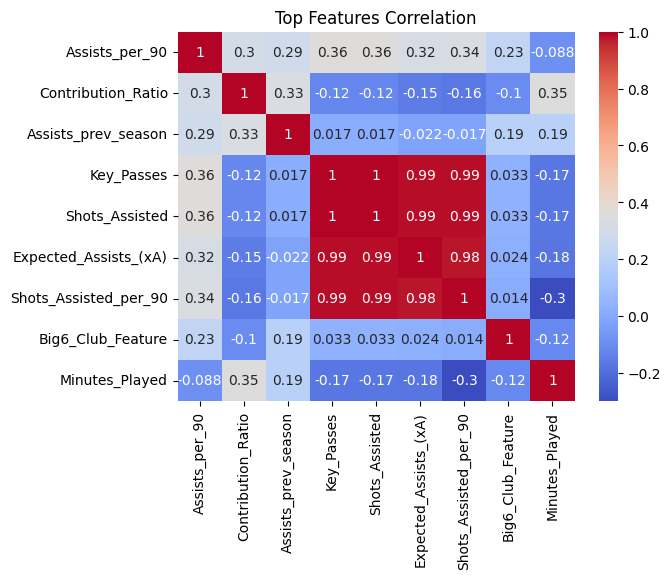

In [17]:
corr = df.corr(numeric_only=True)['Assists'].sort_values(ascending=False)
print("Correlations with Assists:\n", corr)
top_features = corr[1:10].index 
sns.heatmap(df[top_features].corr(), annot=True, cmap="coolwarm")
plt.title("Top Features Correlation")
plt.show()

-----------------------------------------------------------------------------------

**Using L1 Regularization - Lasso Regression**

-----------------------------------------------------------------------------------


In [18]:
from sklearn.linear_model import Lasso

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso_model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lasso", Lasso(alpha=0.001, max_iter=10000))
])

# Fit model
lasso_model.fit(X_train, y_train)

# Predict
y_pred = lasso_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)

Mean Squared Error: 0.0002800190062754735
Root Mean Squared Error: 0.01673376844214935
R² Score: 0.9999629604489053


-------------------------------------------------------------------------------

**Changing Hyperparameters**

-------------------------------------------------------------------------------

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("linreg", LinearRegression())
])

param_grid = {
    "poly__degree": [2, 3, 4],
    "poly__interaction_only": [False, True],
    "linreg__fit_intercept": [True, False]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring="r2")
grid.fit(X, y)

print("Best Params:", grid.best_params_)
print("Best CV R²:", grid.best_score_)


Best Params: {'linreg__fit_intercept': False, 'poly__degree': 2, 'poly__interaction_only': True}
Best CV R²: 0.9999999993404763


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor


pipeline = Pipeline([
    ("dt", DecisionTreeRegressor(random_state=42))
])


param_grid = {
    "dt__criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],  
    "dt__max_depth": [None, 3, 5, 10, 20],              
    "dt__min_samples_split": [2, 5, 10],                
    "dt__min_samples_leaf": [1, 2, 5, 10],              
    "dt__max_features": [None, "sqrt", "log2"]         
}


grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="r2",  
    n_jobs=-1
)

grid.fit(X, y)

print("Best Params:", grid.best_params_)
print("Best CV R²:", grid.best_score_)


Best Params: {'dt__criterion': 'squared_error', 'dt__max_depth': None, 'dt__max_features': None, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 10}
Best CV R²: 0.9262080854951584
